      surface  nombre_de_chambres           prix   latitude  longitude
0  106.611610                   1  565421.520884  44.852275  -0.430788
1   61.475327                   2  362743.051462  44.851056  -0.710735
2   54.953660                   4  377448.568923  44.899378  -0.568239
3   90.644625                   5  597044.762914  44.861396  -0.544870
4  109.141587                   1  592812.309373  44.937837  -0.662089


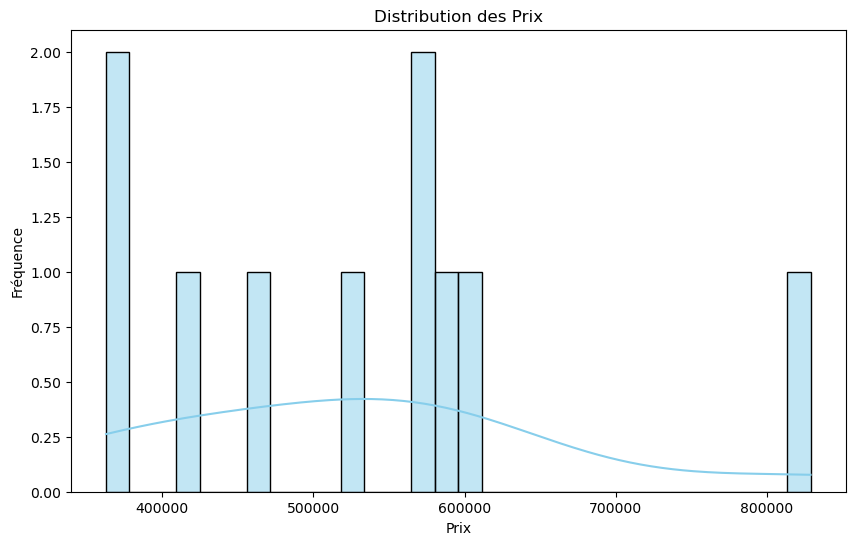

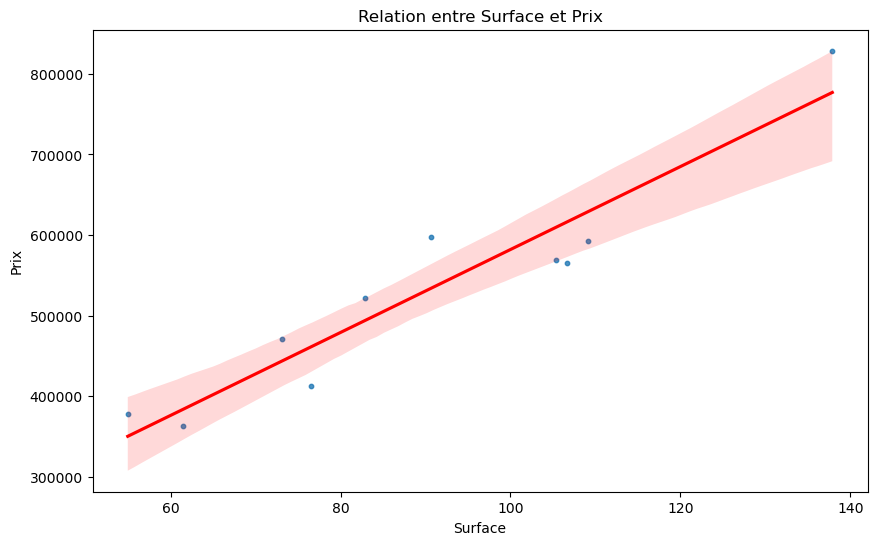

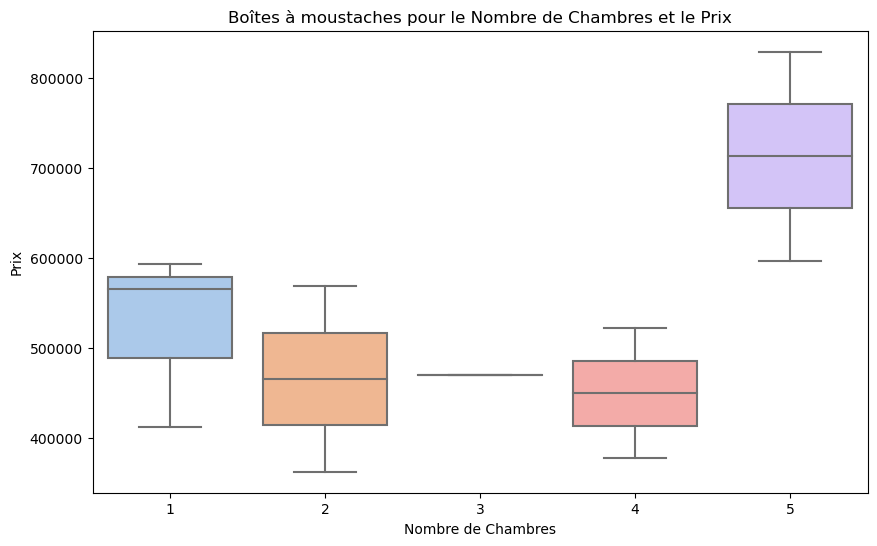

Mean Squared Error : 24265962.38997215
R-squared : 0.9961921694675153
Interception (b0) : 6174.047034342773
Coefficients (b1, b2, ...) : [ 5011.97129719 26500.46106453]


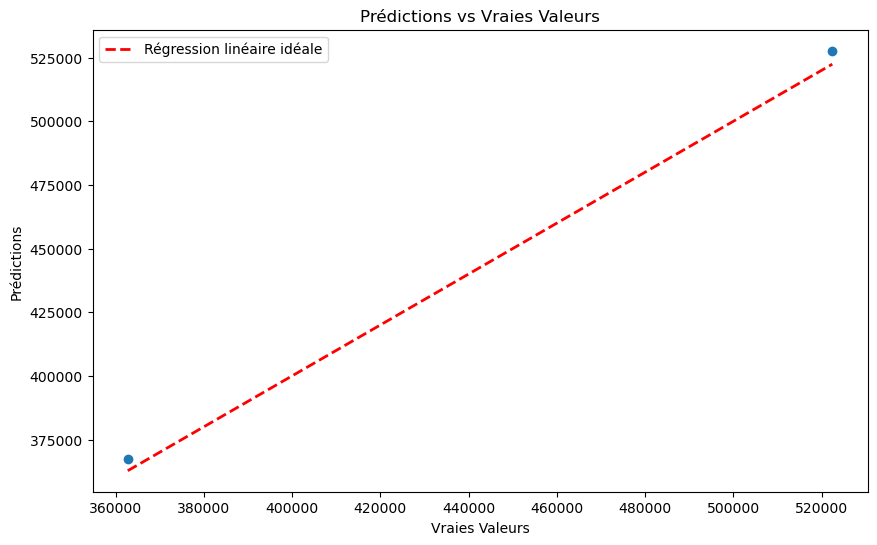

Mean Cross-Validated MSE : 195137460.85824642
Tableau des résultats dans l'intervalle de prix jugé intéressant :
   Nombre_De_Chambres    Surface  Vraies_Valeurs    Prix_Predit      Résidus
1                   2  61.475327   362743.051462  367287.542794 -4544.491332


In [2]:
!pip install geopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import geopy

# Paramètres
np.random.seed(123)  # Pour faire des paramètres aléatoires

# Générer des données fictives pour 10 appartements
num_apartments = 10
surface = np.random.uniform(30, 140, num_apartments)
nombre_de_chambres = np.random.randint(1, 6, num_apartments)
prix = 5000 * surface + 30000 * nombre_de_chambres + np.random.normal(0, 10000, num_apartments)

# Fonction pour générer des coordonnées géographiques aléatoires dans la région de Bordeaux
def generate_random_coordinates(center, radius, num_samples):
    coordinates = []
    for _ in range(num_samples):
        angle = np.random.uniform(0, 2 * np.pi)
        distance = np.sqrt(np.random.uniform(0, 1)) * radius
        new_point = (center[0] + distance * np.cos(angle), center[1] + distance * np.sin(angle))
        coordinates.append(new_point)
    return coordinates

# Coordonnées géographiques du centre de Bordeaux (par exemple)
bordeaux_center = (44.837789, -0.57918)

# Générer des coordonnées géographiques aléatoires dans la région de Bordeaux
radius = 0.15  # Vous pouvez ajuster le rayon selon la taille de la région souhaitée
coordinates = generate_random_coordinates(bordeaux_center, radius, num_apartments)

# Créer un dataframe avec les données générées
data = pd.DataFrame({
    'surface': surface,
    'nombre_de_chambres': nombre_de_chambres,
    'prix': prix,
    'latitude': [coord[0] for coord in coordinates],
    'longitude': [coord[1] for coord in coordinates]
})

# Afficher les premières lignes du dataframe
print(data.head())

# Ajouter une carte de Bordeaux avec la position des appartements
fig = px.scatter_mapbox(data, lat='latitude', lon='longitude', color='prix',
                        size='prix', hover_name='nombre_de_chambres',
                        title='Localisation des Appartements à Bordeaux',
                        mapbox_style="carto-positron", zoom=11)
fig.update_layout(mapbox=dict(center=dict(lat=bordeaux_center[0], lon=bordeaux_center[1]), pitch=0, bearing=0))
fig.show()

# Distribution des prix
plt.figure(figsize=(10, 6))
sns.histplot(data['prix'], bins=30, kde=True, color='skyblue')
plt.title('Distribution des Prix')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.show()

# Relation entre la surface et le prix avec une régression linéaire
plt.figure(figsize=(10, 6))
sns.regplot(x='surface', y='prix', data=data, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Relation entre Surface et Prix')
plt.xlabel('Surface')
plt.ylabel('Prix')
plt.show()

# Boîtes à moustaches pour le nombre de chambres et le prix
plt.figure(figsize=(10, 6))
sns.boxplot(x='nombre_de_chambres', y='prix', data=data, palette='pastel')
plt.title('Boîtes à moustaches pour le Nombre de Chambres et le Prix')
plt.xlabel('Nombre de Chambres')
plt.ylabel('Prix')
plt.show()

# Nuage de points interactif
fig = px.scatter(data, x='surface', y='prix', color='nombre_de_chambres', size='prix',
                 hover_name='nombre_de_chambres', title='Nuage de Points Interactif', labels={'prix': 'Prix'})
fig.show()

# Préparation des données
X = data[['surface', 'nombre_de_chambres']]
y = data['prix']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construction et entraînement du modèle
# Initialiser le modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

# Calculer les métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Afficher les résultats
print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

# Afficher l'interception (b0) et les coefficients (b1, b2, ...)
interception = model.intercept_
coefficients = model.coef_

print(f'Interception (b0) : {interception}')
print(f'Coefficients (b1, b2, ...) : {coefficients}')

# Visualisation des prédictions par rapport aux vraies valeurs
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Régression linéaire idéale')
plt.title('Prédictions vs Vraies Valeurs')
plt.xlabel('Vraies Valeurs')
plt.ylabel('Prédictions')
plt.legend()
plt.show()

# Calcul des résidus (différences entre les vraies valeurs et les prédictions)
residus = y_test - y_pred


from sklearn.model_selection import cross_val_score

# Effectuer une validation croisée pour évaluer la performance du modèle
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
mean_mse_cv = -np.mean(cross_val_scores)

print(f'Mean Cross-Validated MSE : {mean_mse_cv}')

# Création du DataFrame resultats
resultats = pd.DataFrame({'Vraies_Valeurs': y_test, 'Prix_Predit': y_pred, 'Résidus': residus})

# Ajout des colonnes Nombre de chambres, Surface et autres informations à partir de X_test
resultats['Nombre_De_Chambres'] = X_test['nombre_de_chambres'].values
resultats['Surface'] = X_test['surface'].values

# Sélectionner les colonnes intéressantes pour l'affichage
colonnes_affichees = ['Nombre_De_Chambres', 'Surface', 'Vraies_Valeurs', 'Prix_Predit', 'Résidus']

# Définir l'intervalle de prix jugé intéressant (par exemple, entre 100000 et 500000 euros)
intervalle_interessant_min = 100000
intervalle_interessant_max = 500000

# Filtrer les résultats dans l'intervalle intéressant
resultats_interessants = resultats[(resultats['Prix_Predit'] >= intervalle_interessant_min) & (resultats['Prix_Predit'] <= intervalle_interessant_max)]

# Afficher le tableau avec les résultats intéressants
print("Tableau des résultats dans l'intervalle de prix jugé intéressant :")
print(resultats_interessants[colonnes_affichees].head(5))


Mean Squared Error : 142650653.11777404
R-squared : 0.9943498520717698


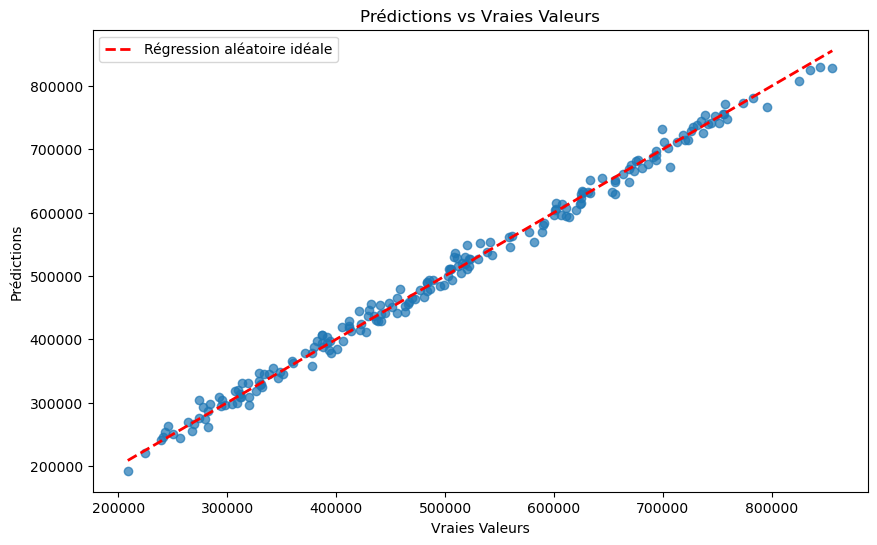

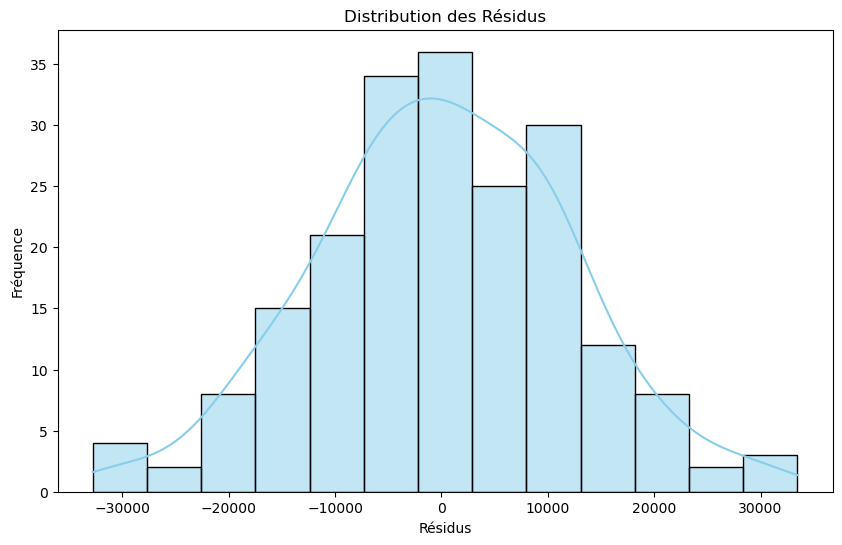

Mean Cross-Validated MSE : 154014515.96891984


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import requests  # Ajout de la bibliothèque pour les requêtes HTTP

# Paramètres
np.random.seed(123)

# Générer des données fictives (peut être remplacé par la lecture d'un fichier CSV)
def generate_fake_data(num_samples=1000):
    surface = np.random.uniform(30, 140, num_samples)
    nombre_de_chambres = np.random.randint(1, 6, num_samples)
    prix = 5000 * surface + 30000 * nombre_de_chambres + np.random.normal(0, 10000, num_samples)
    adresses = ["Adresse" + str(i) for i in range(1, num_samples + 1)]
    data = pd.DataFrame({'surface': surface, 'nombre_de_chambres': nombre_de_chambres, 'prix': prix, 'adresse': adresses})
    return data

# Commentaire : Préparation des données
def prepare_data(data):
    X = data[['surface', 'nombre_de_chambres']]
    y = data['prix']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Commentaire : Construction et entraînement du modèle
def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Commentaire : Évaluation du modèle
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error : {mse}')
    print(f'R-squared : {r2}')

# Commentaire : Visualisation des résultats
def visualize_results(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Régression aléatoire idéale')
    plt.title('Prédictions vs Vraies Valeurs')
    plt.xlabel('Vraies Valeurs')
    plt.ylabel('Prédictions')
    plt.legend()
    plt.show()

# Commentaire : Distribution des résidus
def visualize_residuals(y_test, y_pred):
    residus = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residus, kde=True, color='skyblue')
    plt.title('Distribution des Résidus')
    plt.xlabel('Résidus')
    plt.ylabel('Fréquence')
    plt.show()

# Commentaire : Validation croisée
def cross_validate(model, X, y):
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mean_mse_cv = -np.mean(cross_val_scores)
    print(f'Mean Cross-Validated MSE : {mean_mse_cv}')

# Charger les données (commenter cette ligne lorsque tu auras un CSV)
# data = pd.read_csv('maison.csv')

# Générer des données fictives
data = generate_fake_data()

# Préparation des données
X_train, X_test, y_train, y_test = prepare_data(data)

# Entraînement du modèle
model = train_model(X_train, y_train)

# Évaluation du modèle
evaluate_model(model, X_test, y_test)

# Visualisation des résultats
visualize_results(y_test, model.predict(X_test))

# Distribution des résidus
visualize_residuals(y_test, model.predict(X_test))

# Validation croisée
cross_validate(model, X_train, y_train)

# Sélectionner une adresse d'origine à partir des données
origin_address_index = np.random.choice(X_train.index)
origin_address = data.loc[origin_address_index, 'adresse']



In [3]:
!pip install geopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Paramètres
np.random.seed(123)  # Pour faire des paramètres aléatoires

# Générer des données fictives pour 10 appartements
num_apartments = 10
surface = np.random.uniform(30, 140, num_apartments)
nombre_de_chambres = np.random.randint(1, 6, num_apartments)
prix = 5000 * surface + 30000 * nombre_de_chambres + np.random.normal(0, 10000, num_apartments)

# Fonction pour générer des coordonnées géographiques aléatoires dans la région de Bordeaux
def generate_random_coordinates(center, radius, num_samples):
    coordinates = []
    for _ in range(num_samples):
        angle = np.random.uniform(0, 2 * np.pi)
        distance = np.sqrt(np.random.uniform(0, 1)) * radius
        new_point = (center[0] + distance * np.cos(angle), center[1] + distance * np.sin(angle))
        coordinates.append(new_point)
    return coordinates

# Fonction pour obtenir les coordonnées géographiques d'une adresse
def get_coordinates(address):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.geocode(address)
    return (location.latitude, location.longitude) if location else None

# Coordonnées géographiques du centre de Bordeaux (par exemple)
bordeaux_center = (44.837789, -0.57918)

# Adresse à partir de laquelle vous souhaitez mesurer la distance
target_address = "136 Av. Aristide Briand, 33700 Mérignac"

# Obtenir les coordonnées de l'adresse cible
target_coordinates = get_coordinates(target_address)

if target_coordinates:
    # Générer des coordonnées géographiques aléatoires dans la région de Bordeaux
    radius = 0.15  # Vous pouvez ajuster le rayon selon la taille de la région souhaitée
    coordinates = generate_random_coordinates(bordeaux_center, radius, num_apartments)

    # Créer un dataframe avec les données générées
    data = pd.DataFrame({
        'surface': surface,
        'nombre_de_chambres': nombre_de_chambres,
        'prix': prix,
        'latitude': [coord[0] for coord in coordinates],
        'longitude': [coord[1] for coord in coordinates]
    })

    # Ajouter une colonne de distance à chaque appartement par rapport à l'adresse cible
    data['distance_to_target'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), target_coordinates).kilometers, axis=1)

    # Afficher les premières lignes du dataframe avec la distance ajoutée
    print(data.head())

    # Ajouter une carte de Bordeaux avec la position des appartements
    fig = px.scatter_mapbox(data, lat='latitude', lon='longitude', color='prix',
                            size='prix', hover_name='nombre_de_chambres',
                            title='Localisation des Appartements à Bordeaux',
                            mapbox_style="carto-positron", zoom=11)
    fig.update_layout(mapbox=dict(center=dict(lat=bordeaux_center[0], lon=bordeaux_center[1]), pitch=0, bearing=0))
    fig.show()

    # ... (le reste du code reste inchangé)

else:
    print(f"Impossible d'obtenir les coordonnées de l'adresse : {target_address}")


      surface  nombre_de_chambres           prix   latitude  longitude  \
0  106.611610                   1  565421.520884  44.852275  -0.430788   
1   61.475327                   2  362743.051462  44.851056  -0.710735   
2   54.953660                   4  377448.568923  44.899378  -0.568239   
3   90.644625                   5  597044.762914  44.861396  -0.544870   
4  109.141587                   1  592812.309373  44.937837  -0.662089   

   distance_to_target  
0           15.758532  
1            7.281394  
2            9.469489  
3            7.613833  
4           12.869903  


      surface  nombre_de_chambres           prix   latitude  longitude
0  106.611610                   1  565421.520884  44.852275  -0.430788
1   61.475327                   2  362743.051462  44.851056  -0.710735
2   54.953660                   4  377448.568923  44.899378  -0.568239
3   90.644625                   5  597044.762914  44.861396  -0.544870
4  109.141587                   1  592812.309373  44.937837  -0.662089


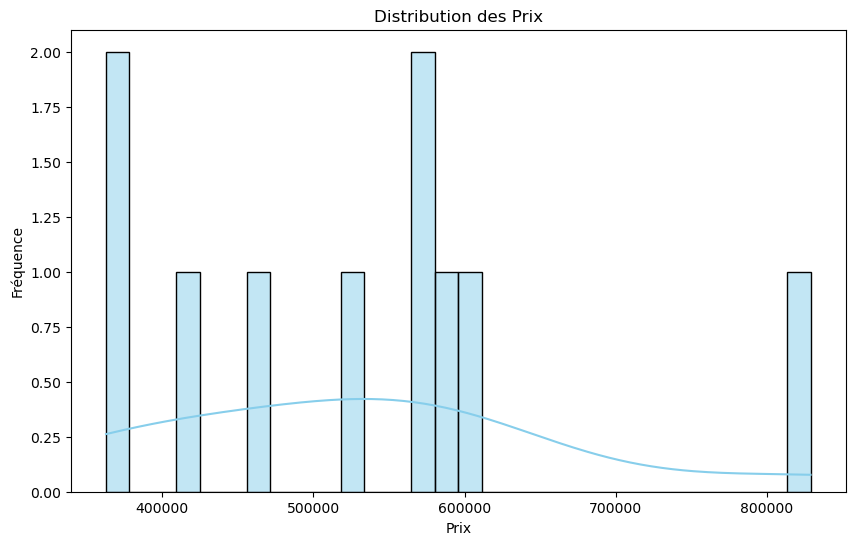

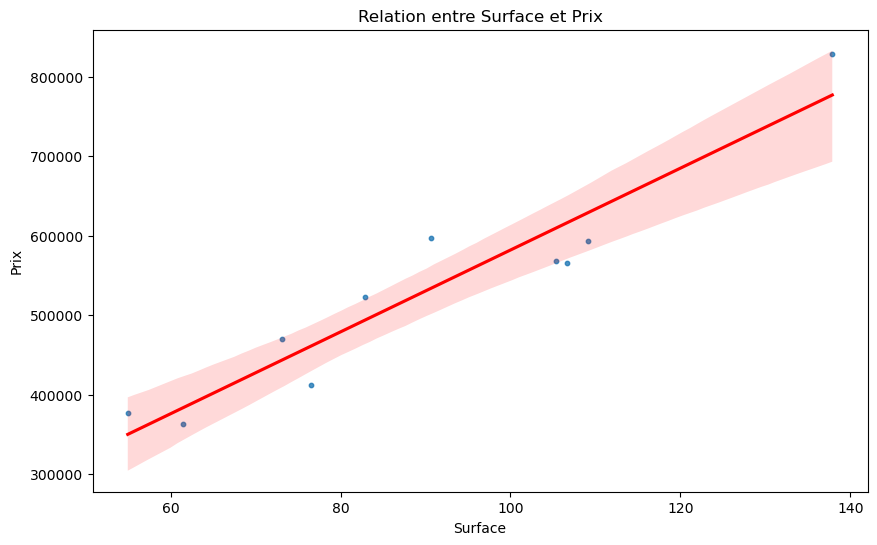

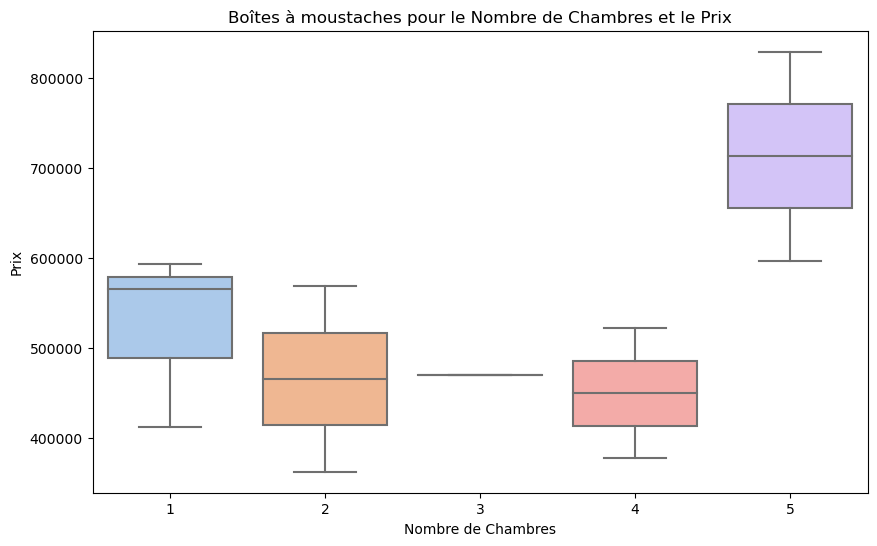

Mean Squared Error : 24265962.38997215
R-squared : 0.9961921694675153


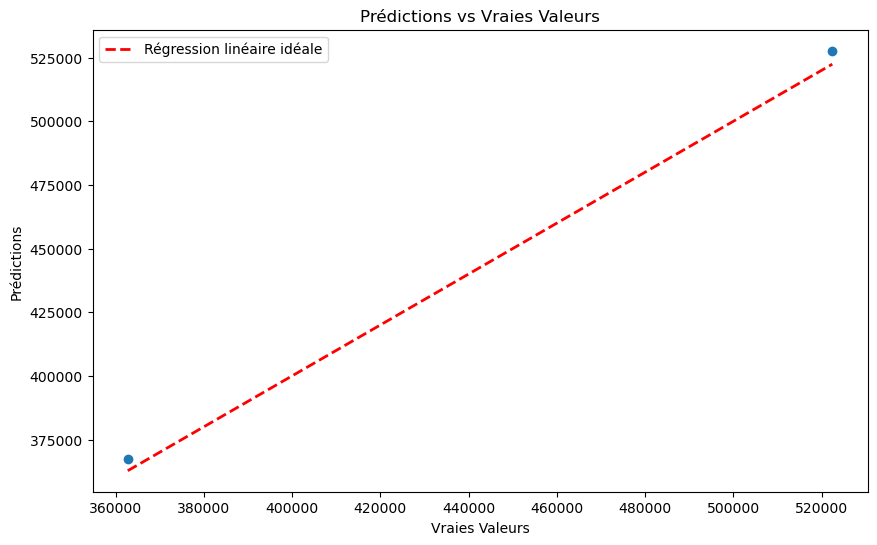

Mean Cross-Validated MSE : 195137460.85824642
Tableau des résultats dans l'intervalle de prix jugé intéressant :
   Nombre_De_Chambres    Surface  Vraies_Valeurs    Prix_Predit      Résidus
1                   2  61.475327   362743.051462  367287.542794 -4544.491332
Mean Squared Error : 157334222.42020005
R-squared : 0.9933485192818601


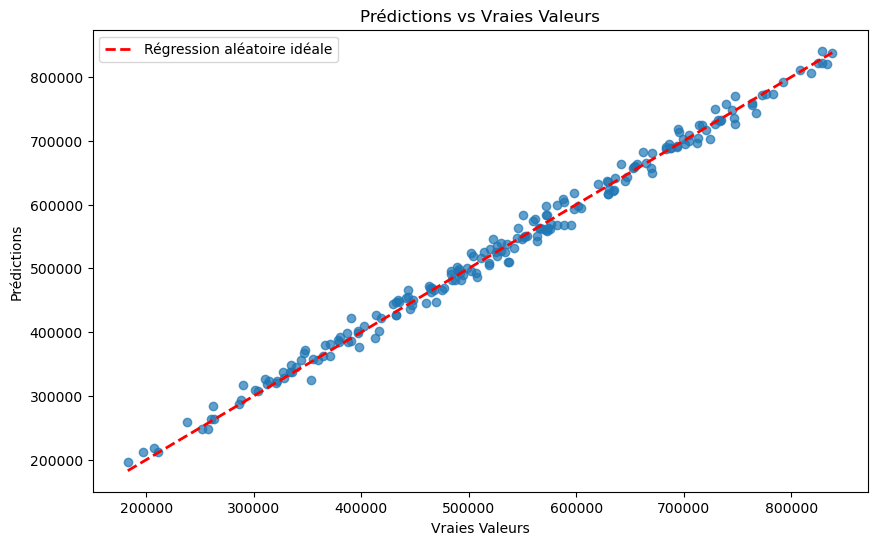

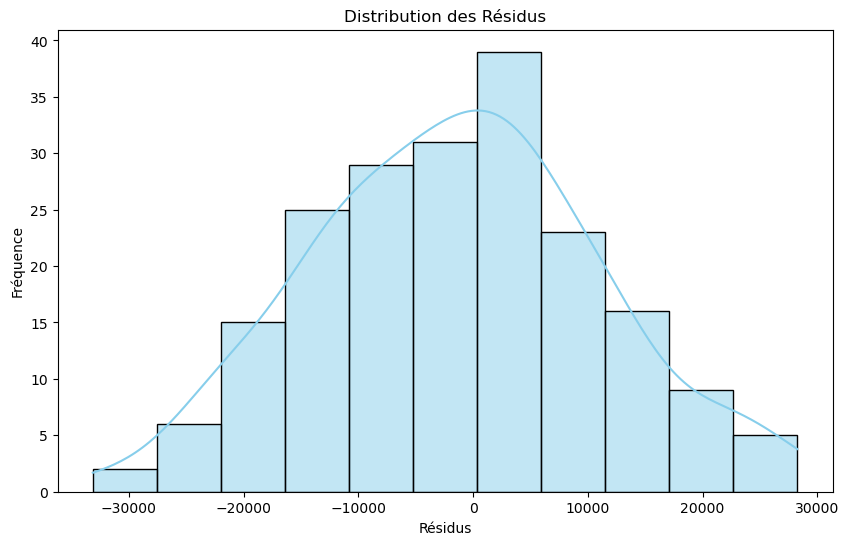

Mean Cross-Validated MSE : 155722852.84048432
Error retrieving transport time from Adresse197 to 136 Av. Aristide Briand, 33700 Mérignac
      surface  nombre_de_chambres           prix   latitude  longitude  \
0   55.978770                   3  364274.356085  44.862608  -0.444232   
1   78.521836                   3  500480.459861  44.895071  -0.546037   
2   52.442193                   3  353491.416141  44.888407  -0.649919   
3  120.118754                   2  666154.681042  44.823303  -0.520483   
4   50.275242                   2  333058.626692  44.803185  -0.656763   

   distance_to_target  
0           14.995800  
1           10.058154  
2            7.304803  
3            8.372964  
4            3.404812  


In [4]:
!pip install geopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import requests  # Ajout de la bibliothèque pour les requêtes HTTP
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Partie 1: Modélisation des Prix des Appartements

# Génération de données fictives pour 10 appartements
np.random.seed(123)
num_apartments = 10
surface = np.random.uniform(30, 140, num_apartments)
nombre_de_chambres = np.random.randint(1, 6, num_apartments)
prix = 5000 * surface + 30000 * nombre_de_chambres + np.random.normal(0, 10000, num_apartments)

# Fonction pour générer des coordonnées géographiques aléatoires dans la région de Bordeaux
def generate_random_coordinates(center, radius, num_samples):
    coordinates = []
    for _ in range(num_samples):
        angle = np.random.uniform(0, 2 * np.pi)
        distance = np.sqrt(np.random.uniform(0, 1)) * radius
        new_point = (center[0] + distance * np.cos(angle), center[1] + distance * np.sin(angle))
        coordinates.append(new_point)
    return coordinates

# Coordonnées géographiques du centre de Bordeaux (par exemple)
bordeaux_center = (44.837789, -0.57918)

# Générer des coordonnées géographiques aléatoires dans la région de Bordeaux
radius = 0.15
coordinates = generate_random_coordinates(bordeaux_center, radius, num_apartments)

# Créer un dataframe avec les données générées
data = pd.DataFrame({
    'surface': surface,
    'nombre_de_chambres': nombre_de_chambres,
    'prix': prix,
    'latitude': [coord[0] for coord in coordinates],
    'longitude': [coord[1] for coord in coordinates]
})

# Afficher les premières lignes du dataframe
print(data.head())

# Ajouter une carte de Bordeaux avec la position des appartements
fig = px.scatter_mapbox(data, lat='latitude', lon='longitude', color='prix',
                        size='prix', hover_name='nombre_de_chambres',
                        title='Localisation des Appartements à Bordeaux',
                        mapbox_style="carto-positron", zoom=11)
fig.update_layout(mapbox=dict(center=dict(lat=bordeaux_center[0], lon=bordeaux_center[1]), pitch=0, bearing=0))
fig.show()

# Distribution des prix
plt.figure(figsize=(10, 6))
sns.histplot(data['prix'], bins=30, kde=True, color='skyblue')
plt.title('Distribution des Prix')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.show()

# Relation entre la surface et le prix avec une régression linéaire
plt.figure(figsize=(10, 6))
sns.regplot(x='surface', y='prix', data=data, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Relation entre Surface et Prix')
plt.xlabel('Surface')
plt.ylabel('Prix')
plt.show()

# Boîtes à moustaches pour le nombre de chambres et le prix
plt.figure(figsize=(10, 6))
sns.boxplot(x='nombre_de_chambres', y='prix', data=data, palette='pastel')
plt.title('Boîtes à moustaches pour le Nombre de Chambres et le Prix')
plt.xlabel('Nombre de Chambres')
plt.ylabel('Prix')
plt.show()

# Nuage de points interactif
fig = px.scatter(data, x='surface', y='prix', color='nombre_de_chambres', size='prix',
                 hover_name='nombre_de_chambres', title='Nuage de Points Interactif', labels={'prix': 'Prix'})
fig.show()

# Préparation des données pour la modélisation
X = data[['surface', 'nombre_de_chambres']]
y = data['prix']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construction et entraînement du modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

# Visualisation des prédictions par rapport aux vraies valeurs
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2,
         label='Régression linéaire idéale')
plt.title('Prédictions vs Vraies Valeurs')
plt.xlabel('Vraies Valeurs')
plt.ylabel('Prédictions')
plt.legend()
plt.show()

# Validation croisée pour évaluer la performance du modèle
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
mean_mse_cv = -np.mean(cross_val_scores)
print(f'Mean Cross-Validated MSE : {mean_mse_cv}')

# Création du DataFrame resultats
resultats = pd.DataFrame({'Vraies_Valeurs': y_test, 'Prix_Predit': y_pred, 'Résidus': y_test - y_pred})

# Ajout des colonnes Nombre de chambres, Surface et autres informations à partir de X_test
resultats['Nombre_De_Chambres'] = X_test['nombre_de_chambres'].values
resultats['Surface'] = X_test['surface'].values

# Sélectionner les colonnes intéressantes pour l'affichage
colonnes_affichees = ['Nombre_De_Chambres', 'Surface', 'Vraies_Valeurs', 'Prix_Predit', 'Résidus']

# Définir l'intervalle de prix jugé intéressant
intervalle_interessant_min = 100000
intervalle_interessant_max = 500000

# Filtrer les résultats dans l'intervalle intéressant
resultats_interessants = resultats[(resultats['Prix_Predit'] >= intervalle_interessant_min) & (
        resultats['Prix_Predit'] <= intervalle_interessant_max)]

# Afficher le tableau avec les résultats intéressants
print("Tableau des résultats dans l'intervalle de prix jugé intéressant :")
print(resultats_interessants[colonnes_affichees].head(5))

# Partie 2: Modélisation avec Random Forest

# Fonction pour générer des données fictives (peut être remplacé par la lecture d'un fichier CSV)
def generate_fake_data(num_samples=1000):
    surface = np.random.uniform(30, 140, num_samples)
    nombre_de_chambres = np.random.randint(1, 6, num_samples)
    prix = 5000 * surface + 30000 * nombre_de_chambres + np.random.normal(0, 10000, num_samples)
    adresses = ["Adresse" + str(i) for i in range(1, num_samples + 1)]
    data = pd.DataFrame({'surface': surface, 'nombre_de_chambres': nombre_de_chambres, 'prix': prix, 'adresse': adresses})
    return data

# Commentaire : Préparation des données
def prepare_data(data):
    X = data[['surface', 'nombre_de_chambres']]
    y = data['prix']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Commentaire : Construction et entraînement du modèle
def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Commentaire : Évaluation du modèle
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error : {mse}')
    print(f'R-squared : {r2}')

# Commentaire : Visualisation des résultats
def visualize_results(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2,
             label='Régression aléatoire idéale')
    plt.title('Prédictions vs Vraies Valeurs')
    plt.xlabel('Vraies Valeurs')
    plt.ylabel('Prédictions')
    plt.legend()
    plt.show()

# Commentaire : Distribution des résidus
def visualize_residuals(y_test, y_pred):
    residus = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residus, kde=True, color='skyblue')
    plt.title('Distribution des Résidus')
    plt.xlabel('Résidus')
    plt.ylabel('Fréquence')
    plt.show()

# Commentaire : Validation croisée
def cross_validate(model, X, y):
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mean_mse_cv = -np.mean(cross_val_scores)
    print(f'Mean Cross-Validated MSE : {mean_mse_cv}')

# Obtenir le temps de trajet en transport en commun jusqu'à l'adresse spécifiée
def get_transport_time(origin, destination):
    endpoint = "https://maps.googleapis.com/maps/api/directions/json"
    params = {
        "origin": origin,
        "destination": destination,
        "mode": "transit",
        "key": 'VOTRE_CLE_API'  # Remplacez par votre clé API Google Maps
    }

    response = requests.get(endpoint, params=params)
    result = response.json()

    try:
        duration = result["routes"][0]["legs"][0]["duration"]["text"]
        print(f'Transport Time from {origin} to {destination}: {duration}')
        return duration
    except IndexError:
        print(f'Error retrieving transport time from {origin} to {destination}')
        return None

# Charger les données (commenter cette ligne lorsque tu auras un CSV)
# data = pd.read_csv('maison.csv')

# Générer des données fictives
data = generate_fake_data()

# Préparation des données
X_train, X_test, y_train, y_test = prepare_data(data)

# Entraînement du modèle
model = train_model(X_train, y_train)

# Évaluation du modèle
evaluate_model(model, X_test, y_test)

# Visualisation des résultats
visualize_results(y_test, model.predict(X_test))

# Distribution des résidus
visualize_residuals(y_test, model.predict(X_test))

# Validation croisée
cross_validate(model, X_train, y_train)

# Sélectionner une adresse d'origine à partir des données
origin_address_index = np.random.choice(X_train.index)
origin_address = data.loc[origin_address_index, 'adresse']

# Obtenir le temps de trajet en transport en commun jusqu'à l'adresse spécifiée
destination_address = "136 Av. Aristide Briand, 33700 Mérignac"
transport_time = get_transport_time(origin_address, destination_address)

# Partie 3: Ajout de Coordonnées Géographiques Réelles

# Génération de données fictives pour 10 appartements
num_apartments = 10
surface = np.random.uniform(30, 140, num_apartments)
nombre_de_chambres = np.random.randint(1, 6, num_apartments)
prix = 5000 * surface + 30000 * nombre_de_chambres + np.random.normal(0, 10000, num_apartments)

# Fonction pour obtenir les coordonnées géographiques d'une adresse
def get_coordinates(address):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.geocode(address)
    return (location.latitude, location.longitude) if location else None

# Adresse à partir de laquelle vous souhaitez mesurer la distance
target_address = "136 Av. Aristide Briand, 33700 Mérignac"

# Obtenir les coordonnées de l'adresse cible
target_coordinates = get_coordinates(target_address)

if target_coordinates:
    # Générer des coordonnées géographiques aléatoires dans la région de Bordeaux
    radius = 0.15
    coordinates = generate_random_coordinates(bordeaux_center, radius, num_apartments)

    # Créer un dataframe avec les données générées
    data = pd.DataFrame({
        'surface': surface,
        'nombre_de_chambres': nombre_de_chambres,
        'prix': prix,
        'latitude': [coord[0] for coord in coordinates],
        'longitude': [coord[1] for coord in coordinates]
    })

    # Ajouter une colonne de distance à chaque appartement par rapport à l'adresse cible
    data['distance_to_target'] = data.apply(
        lambda row: geodesic((row['latitude'], row['longitude']), target_coordinates).kilometers, axis=1)

    # Afficher les premières lignes du dataframe avec la distance ajoutée
    print(data.head())

    # Ajouter une carte de Bordeaux avec la position des appartements
    fig = px.scatter_mapbox(data, lat='latitude', lon='longitude', color='prix',
                            size='prix', hover_name='nombre_de_chambres',
                            title='Localisation des Appartements à Bordeaux',
                            mapbox_style="carto-positron", zoom=11)
    fig.update_layout(mapbox=dict(center=dict(lat=bordeaux_center[0], lon=bordeaux_center[1]), pitch=0, bearing=0))
    fig.show()

    # ... (le reste du code reste inchangé)

else:
    print(f"Impossible d'obtenir les coordonnées de l'adresse : {target_address}")
